<a href="https://colab.research.google.com/github/sur-sakthy/computer-vision/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #1

In [1]:
!nvidia-smi

Sat Mar 18 10:14:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cp '/content/drive/MyDrive/EE544 Computer Vision/imagenette2-160.tgz' ./

In [3]:
# remove %%capture command to show output from unzipping
%%capture 
!tar zxvf /content/imagenette2-160.tgz

## Imports

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, AUC, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Constants

In [5]:
PATH_TO_TRAIN_DATA = '/content/imagenette2-160/train'
PATH_TO_VAL_DATA = '/content/imagenette2-160/val'

IMG_WIDTH=64
IMG_HEIGHT=64

NUM_CLASSES=4

In [6]:
all_classes = os.listdir(PATH_TO_TRAIN_DATA)
all_classes

['n03888257',
 'n02979186',
 'n02102040',
 '.DS_Store',
 'n03417042',
 'n03028079',
 'n03000684',
 'n03394916',
 'n03425413',
 'n01440764',
 'n03445777']

In [7]:
all_classes = os.listdir(PATH_TO_VAL_DATA)
all_classes

['n03888257',
 'n02979186',
 'n02102040',
 'n03417042',
 'n03028079',
 'n03000684',
 'n03394916',
 'n03425413',
 'n01440764',
 'n03445777']

## Load dataset

In [8]:
data = []
labels = []

In [9]:
def load_dataset(img_folder): 
    for dir in os.listdir(img_folder):
      if dir == 'n03445777' or dir == 'n03417042' or dir == 'n02979186' or dir == 'n03028079' :
        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path = os.path.join(img_folder, dir, file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
            image = np.array(image)

            data.append(image)
            labels.append(dir)

In [10]:
load_dataset(PATH_TO_TRAIN_DATA)
load_dataset(PATH_TO_VAL_DATA)

In [11]:
np.unique(labels)

array(['n02979186', 'n03028079', 'n03417042', 'n03445777'], dtype='<U9')

In [12]:
data[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

## Class distribution

In [14]:
df_train = pd.DataFrame(y_train, columns=['label'])
df_train.head()

,label
0,n03028079
1,n02979186
2,n02979186
3,n03028079
4,n03445777


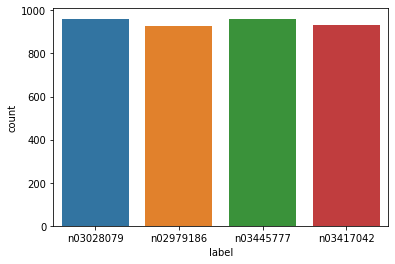

In [15]:
sns.countplot(data=df_train, x='label')
plt.show()

In [16]:
df_test = pd.DataFrame(y_test, columns=['label'])
df_test.head()

,label
0,n03028079
1,n02979186
2,n03417042
3,n03417042
4,n02979186


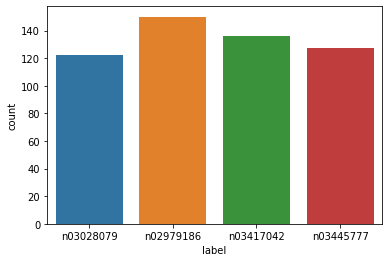

In [17]:
sns.countplot(data=df_test, x='label')
plt.show()

In [18]:
df_val = pd.DataFrame(y_val, columns=['label'])
df_val.head()

,label
0,n03028079
1,n03445777
2,n03028079
3,n03028079
4,n03028079


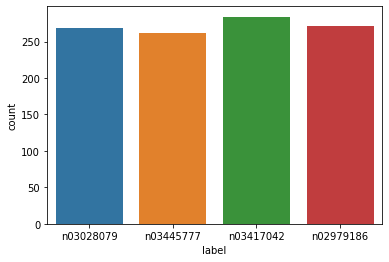

In [19]:
sns.countplot(data=df_val, x='label')
plt.show()

## Encoding

In [20]:
def one_hot_encode(y, num_classes):
  le = LabelEncoder()
  return to_categorical(le.fit_transform(y), num_classes)

In [21]:
y_train[0]

'n03028079'

In [22]:
y_train = one_hot_encode(y_train, NUM_CLASSES)

In [23]:
y_train[0]

array([0., 1., 0., 0.], dtype=float32)

In [24]:
y_test[0]

'n03028079'

In [25]:
y_test = one_hot_encode(y_test, NUM_CLASSES)

In [26]:
y_test[0]

array([0., 1., 0., 0.], dtype=float32)

In [27]:
np.array(y_train).shape

(3780, 4)

In [28]:
y_val[0]

'n03028079'

In [29]:
y_val = one_hot_encode(y_val, NUM_CLASSES)

In [30]:
y_val

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

## Create train, validation and test sets

In [31]:
train_datagen = ImageDataGenerator(        
        rescale=1./255,
        fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
train_ds = train_datagen.flow(
  np.array(X_train), y_train,
  shuffle=True,
  batch_size=128
)

val_ds = val_datagen.flow(
  np.array(X_val), y_val,
  shuffle=True,
  batch_size=128
)

test_ds = test_datagen.flow(
  np.array(X_test), y_test,
  shuffle=False,
  batch_size=128
)

In [33]:
print('Shape of training samples: ', train_ds.x.shape)
print('Shape of validation samples: ', val_ds.x.shape)
print('Shape of test samples: ', test_ds.x.shape)

Shape of training samples:  (3780, 64, 64, 3)
Shape of validation samples:  (1085, 64, 64, 3)
Shape of test samples:  (535, 64, 64, 3)


## Build model

In [34]:
def build_model(batchNorm=False, dropOut=False, l2Reg=False):
  model = Sequential()

  if l2Reg:
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  if l2Reg:
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  model.add(Flatten())

  if l2Reg:
    model.add(Dense(512, kernel_regularizer='l2'))
  else:
    model.add(Dense(512))
  
  if dropOut:
    model.add(Dropout(0.25))

  if l2Reg:
    model.add(Dense(NUM_CLASSES, activation='softmax', kernel_regularizer='l2'))
  else:
    model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(
      optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=[
          CategoricalAccuracy(),
          Precision(), 
          Recall(),
          AUC()
        ]
  )

  return model

In [35]:
baseline_model = build_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

## Train model

### Initialise callbacks

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5', verbose=1, save_best_only=True, monitor='val_categorical_accuracy')

### Fit the model

In [37]:
baseline_history = baseline_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/30
29/30 [============================>.] - ETA: 0s - loss: 1.4704 - categorical_accuracy: 0.4480 - precision: 0.4979 - recall: 0.1284 - auc: 0.6857
Epoch 1: val_categorical_accuracy improved from -inf to 0.49585, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5
30/30 [==============================] - 14s 101ms/step - loss: 1.4595 - categorical_accuracy: 0.4508 - precision: 0.5057 - recall: 0.1397 - auc: 0.6890 - val_loss: 1.3178 - val_categorical_accuracy: 0.4959 - val_precision: 0.5573 - val_recall: 0.4304 - val_auc: 0.7539
Epoch 2/30
29/30 [============================>.] - ETA: 0s - loss: 0.8596 - categorical_accuracy: 0.6495 - precision: 0.7414 - recall: 0.5323 - auc: 0.8731
Epoch 2: val_categorical_accuracy improved from 0.49585 to 0.67834, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5
30/30 [==============================] - 1s 46ms/step - loss: 0.8578 - categorical_accuracy: 0.6505 - precision: 0.7402 -

## Plot results

In [38]:
def plot(train, validation, ylabel, title):
  plt.plot(train, color='red', label='train') 
  plt.plot(validation, color='blue', label='validation') 
  plt.title(title) 
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend() 
  plt.grid(linestyle='-', linewidth=0.5)

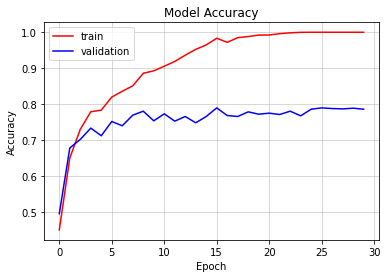

In [39]:
plot(baseline_history.history['categorical_accuracy'], baseline_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

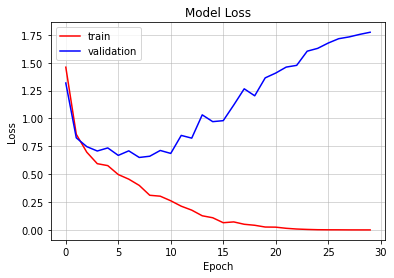

In [40]:
plot(baseline_history.history['loss'], baseline_history.history['val_loss'], 'Loss', 'Model Loss')

## Evaluate model

In [41]:
def evaluate_and_predict(model): 
  # evaluate on test dataset
  eval_results = model.evaluate(test_ds, batch_size=30)

  # print evaluation results
  print('Test loss:', eval_results[0])
  print('Test categorical_accuracy:', eval_results[1])
  print('Test precision:', eval_results[2])
  print('Test recall:', eval_results[3])
  print('Test auc:', eval_results[4])

  # predict
  return model.predict(test_ds)

In [42]:
pred = evaluate_and_predict(baseline_model)

5/5 [==============================] - 0s 34ms/step - loss: 1.3286 - categorical_accuracy: 0.8262 - precision: 0.8271 - recall: 0.8224 - auc: 0.9302
Test loss: 1.3286137580871582
Test categorical_accuracy: 0.8261682391166687
Test precision: 0.8270676732063293
Test recall: 0.822429895401001
Test auc: 0.9301556944847107
5/5 [==============================] - 0s 11ms/step


In [43]:
pred

array([[8.4868147e-11, 1.0000000e+00, 1.2046555e-11, 4.0186773e-08],
       [6.4260966e-01, 4.2547010e-10, 3.5739034e-01, 4.0912447e-14],
       [1.3106530e-15, 9.1043894e-06, 9.9999094e-01, 2.0680625e-12],
       ...,
       [9.9999821e-01, 1.0713179e-19, 1.8260299e-06, 3.2767096e-12],
       [3.3501622e-12, 1.0000000e+00, 5.8214616e-14, 1.7375434e-13],
       [1.0000000e+00, 1.2252081e-13, 3.4425957e-10, 6.9219792e-19]],
      dtype=float32)

In [44]:
def draw_confusion_matrix(true, pred):
  cm = confusion_matrix(true.argmax(axis=1), pred.argmax(axis=1))
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
  plt.show()

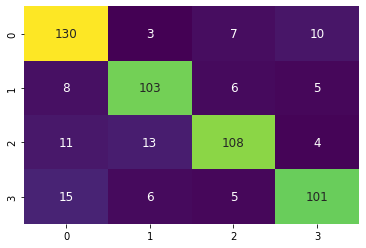

In [45]:
draw_confusion_matrix(y_test, pred)

In [46]:
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       150
           1       0.82      0.84      0.83       122
           2       0.86      0.79      0.82       136
           3       0.84      0.80      0.82       127

    accuracy                           0.83       535
   macro avg       0.83      0.83      0.83       535
weighted avg       0.83      0.83      0.83       535



## Improve the baseline networks performance
1. Batch Normalisation 
2. Dropout 
3. Regularisation

### Batch Normalisation

In [47]:
batchnorm_model = build_model(batchNorm=True)
batchnorm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)       

In [48]:
batchnorm_history = batchnorm_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 5s 67ms/step - loss: 5.6077 - categorical_accuracy: 0.5952 - precision_1: 0.5979 - recall_1: 0.5915 - auc_1: 0.7780 - val_loss: 1.6354 - val_categorical_accuracy: 0.3263 - val_precision_1: 0.4102 - val_recall_1: 0.2590 - val_auc_1: 0.5885
Epoch 2/30
30/30 [==============================] - 1s 45ms/step - loss: 1.8470 - categorical_accuracy: 0.7437 - precision_1: 0.7457 - recall_1: 0.7415 - auc_1: 0.8869 - val_loss: 1.5725 - val_categorical_accuracy: 0.3152 - val_precision_1: 0.3399 - val_recall_1: 0.2240 - val_auc_1: 0.6096
Epoch 3/30
30/30 [==============================] - 1s 39ms/step - loss: 0.7591 - categorical_accuracy: 0.8333 - precision_1: 0.8372 - recall_1: 0.8299 - auc_1: 0.9490 - val_loss: 1.8745 - val_categorical_accuracy: 0.3069 - val_precision_1: 0.3463 - val_recall_1: 0.2710 - val_auc_1: 0.5782
Epoch 4/30
30/30 [==============================] - 1s 39ms/step - loss: 0.2970 - categorical_accuracy: 0.9103 - precision_1: 0

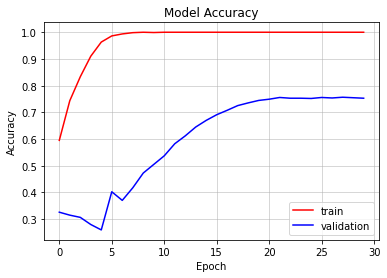

In [49]:
plot(batchnorm_history.history['categorical_accuracy'], batchnorm_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

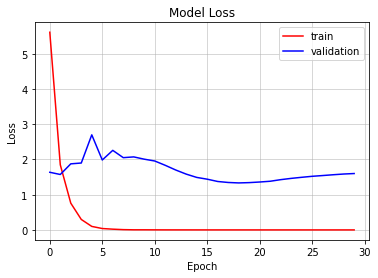

In [50]:
plot(batchnorm_history.history['loss'], batchnorm_history.history['val_loss'], 'Loss', 'Model Loss')

In [51]:
batchnorm_pred = evaluate_and_predict(batchnorm_model)

5/5 [==============================] - 0s 21ms/step - loss: 1.2595 - categorical_accuracy: 0.7944 - precision_1: 0.8011 - recall_1: 0.7907 - auc_1: 0.9202
Test loss: 1.2595421075820923
Test categorical_accuracy: 0.7943925261497498
Test precision: 0.8011363744735718
Test recall: 0.790654182434082
Test auc: 0.9202463626861572
5/5 [==============================] - 0s 17ms/step


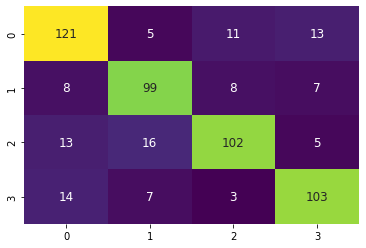

In [52]:
draw_confusion_matrix(y_test, batchnorm_pred)

In [53]:
print(classification_report(y_test.argmax(axis=1), batchnorm_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       150
           1       0.78      0.81      0.80       122
           2       0.82      0.75      0.78       136
           3       0.80      0.81      0.81       127

    accuracy                           0.79       535
   macro avg       0.80      0.79      0.79       535
weighted avg       0.80      0.79      0.79       535



### Dropout

In [54]:
dropout_model = build_model(dropOut=True)
dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [55]:
dropout_history = dropout_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 4s 50ms/step - loss: 1.3370 - categorical_accuracy: 0.4167 - precision_2: 0.5675 - recall_2: 0.1413 - auc_2: 0.6809 - val_loss: 1.0173 - val_categorical_accuracy: 0.5806 - val_precision_2: 0.7014 - val_recall_2: 0.4157 - val_auc_2: 0.8164
Epoch 2/30
30/30 [==============================] - 1s 38ms/step - loss: 0.8836 - categorical_accuracy: 0.6323 - precision_2: 0.7126 - recall_2: 0.5077 - auc_2: 0.8648 - val_loss: 0.8443 - val_categorical_accuracy: 0.6590 - val_precision_2: 0.7481 - val_recall_2: 0.5447 - val_auc_2: 0.8772
Epoch 3/30
30/30 [==============================] - 1s 37ms/step - loss: 0.7380 - categorical_accuracy: 0.7098 - precision_2: 0.7681 - recall_2: 0.6310 - auc_2: 0.9076 - val_loss: 0.9919 - val_categorical_accuracy: 0.5926 - val_precision_2: 0.6427 - val_recall_2: 0.5355 - val_auc_2: 0.8429
Epoch 4/30
30/30 [==============================] - 1s 38ms/step - loss: 0.7028 - categorical_accuracy: 0.7265 - precision_2: 0

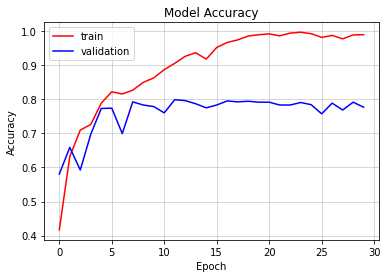

In [56]:
plot(dropout_history.history['categorical_accuracy'], dropout_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

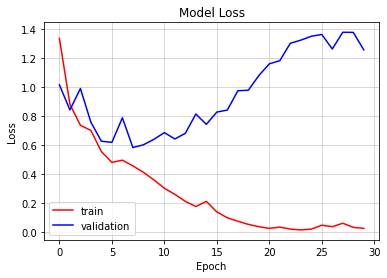

In [57]:
plot(dropout_history.history['loss'], dropout_history.history['val_loss'], 'Loss', 'Model Loss')

In [58]:
dropout_pred = evaluate_and_predict(dropout_model)

5/5 [==============================] - 0s 17ms/step - loss: 0.8071 - categorical_accuracy: 0.8355 - precision_2: 0.8380 - recall_2: 0.8318 - auc_2: 0.9454
Test loss: 0.8070990443229675
Test categorical_accuracy: 0.8355140089988708
Test precision: 0.8380414247512817
Test recall: 0.8317757248878479
Test auc: 0.9454333782196045
5/5 [==============================] - 0s 11ms/step


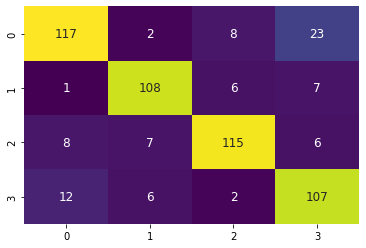

In [59]:
draw_confusion_matrix(y_test, dropout_pred)

In [60]:
print(classification_report(y_test.argmax(axis=1), dropout_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       150
           1       0.88      0.89      0.88       122
           2       0.88      0.85      0.86       136
           3       0.75      0.84      0.79       127

    accuracy                           0.84       535
   macro avg       0.84      0.84      0.84       535
weighted avg       0.84      0.84      0.84       535



### L2 Regularisation

In [61]:
l2reg_model = build_model(l2Reg=True)
l2reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [62]:
l2reg_history = l2reg_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 4s 51ms/step - loss: 5.6841 - categorical_accuracy: 0.3688 - precision_3: 0.4519 - recall_3: 0.0373 - auc_3: 0.6303 - val_loss: 2.5721 - val_categorical_accuracy: 0.3991 - val_precision_3: 0.4990 - val_recall_3: 0.2221 - val_auc_3: 0.7154
Epoch 2/30
30/30 [==============================] - 1s 38ms/step - loss: 2.0006 - categorical_accuracy: 0.5553 - precision_3: 0.7049 - recall_3: 0.3286 - auc_3: 0.8090 - val_loss: 1.6612 - val_categorical_accuracy: 0.6221 - val_precision_3: 0.7442 - val_recall_3: 0.4157 - val_auc_3: 0.8469
Epoch 3/30
30/30 [==============================] - 1s 38ms/step - loss: 1.4998 - categorical_accuracy: 0.6423 - precision_3: 0.7337 - recall_3: 0.4897 - auc_3: 0.8688 - val_loss: 1.4675 - val_categorical_accuracy: 0.6111 - val_precision_3: 0.7080 - val_recall_3: 0.4627 - val_auc_3: 0.8548
Epoch 4/30
30/30 [==============================] - 1s 38ms/step - loss: 1.3240 - categorical_accuracy: 0.6886 - precision_3: 0

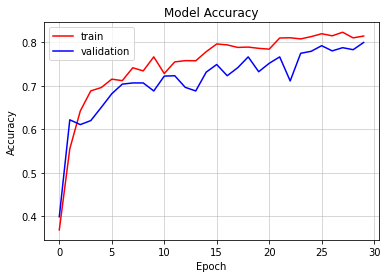

In [63]:
plot(l2reg_history.history['categorical_accuracy'], l2reg_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

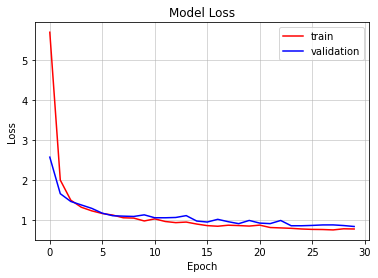

In [64]:
plot(l2reg_history.history['loss'], l2reg_history.history['val_loss'], 'Loss', 'Model Loss')

In [65]:
l2reg_pred = evaluate_and_predict(l2reg_model)

5/5 [==============================] - 0s 12ms/step - loss: 0.7754 - categorical_accuracy: 0.8206 - precision_3: 0.8439 - recall_3: 0.7682 - auc_3: 0.9564
Test loss: 0.7753691673278809
Test categorical_accuracy: 0.8205607533454895
Test precision: 0.8439425230026245
Test recall: 0.76822429895401
Test auc: 0.9564299583435059
5/5 [==============================] - 0s 15ms/step


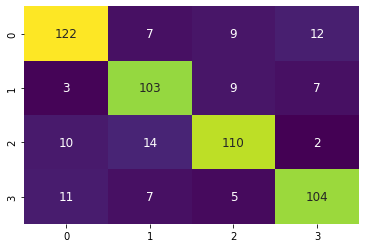

In [66]:
draw_confusion_matrix(y_test, l2reg_pred)

In [68]:
print(classification_report(y_test.argmax(axis=1), l2reg_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       150
           1       0.79      0.84      0.81       122
           2       0.83      0.81      0.82       136
           3       0.83      0.82      0.83       127

    accuracy                           0.82       535
   macro avg       0.82      0.82      0.82       535
weighted avg       0.82      0.82      0.82       535

